In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import ViTForImageClassification, AutoProcessor
from pathlib import Path
import os

import sys; sys.path.append("../src/")
from stability import soft_stability_rate
from models import MaskedImageClassifier, CertifiedMuSImageClassifier, discretized_mus_masks
from data_utils import load_images_from_directory
from explanations import \
    get_lime_for_image, get_shap_for_image, get_intgrad_for_image, get_mfaba_for_image
from visualizations import add_k_ones_enumerate, vis_masked_img, get_top_k_predictions, get_labels_containing_keyword
from visualizations import set_random_seed, MaskedImageClassifierNew, CertifiedMuSImageClassifierNew

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Load images; they will be ordered the same every time.
images = load_images_from_directory("/shared_data0/helenjin/imagenet-sample-images/")
# images = images[:20]
print(images.shape)

torch.Size([1000, 3, 224, 224])


In [115]:
# Load the model. This should be our custom fine-tuned models later!
raw_vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
raw_vit.eval().to(device);
processor = AutoProcessor.from_pretrained('google/vit-base-patch16-224')

In [116]:
# raw_vit.load_state_dict(torch.load('/shared_data0/antonxue/google_vit_patch16_img224_bsz128_lr0.0001_epoch5.pt')['state_dict'])

In [117]:
images.min(), images.max()

(tensor(-1.), tensor(1.))

In [118]:
# torch.tensor(processor(images[0])['pixel_values']).min(), torch.tensor(processor(images[0])['pixel_values']).max()

In [119]:
import torch
from torchvision.transforms import ToPILImage

# Example tensor (C, H, W) in range [0, 1]
tensor = torch.rand(3, 256, 256)  # Example RGB image

# Convert to PIL image
to_pil = ToPILImage()
pil_image = to_pil(tensor)

# Show image
# pil_image.show()


image_proc = torch.tensor(processor(to_pil(images[0]))['pixel_values'])

In [120]:
image_proc.min(), image_proc.max()

(tensor(-1.), tensor(0.9922))

In [121]:
images.min(), images.max()

(tensor(-1.), tensor(1.))

In [122]:
grid_size = 3

In [228]:
wrapped_vit = MaskedImageClassifierNew(raw_vit, grid_size=(grid_size,grid_size)).to(device)
wrapped_vit.eval();
cert_mus_vit = CertifiedMuSImageClassifierNew(raw_vit, lambda_=0.5, 
                                              grid_size=(grid_size,grid_size),
                                             quant=256).to(device)
cert_mus_vit.eval();

In [229]:
wrapped_vit.grid_size

(3, 3)

In [230]:
# cand_idxs = [150, 3, 11, 14, 17, 19, 93, 112,157,169,174, 194]

In [231]:
def check_pred_same(wrapped_vit, cert_mus_vit, image, label, alpha=None): # label = img_idx
    wrapped_vit_pred = wrapped_vit(image.to(device), alpha).argmax(-1).item()
    cert_mus_vit_pred = cert_mus_vit(image.to(device), alpha)['logits'].argmax(-1).item()
    # print('wrapped_vit_pred', wrapped_vit_pred, 'cert_mus_vit_pred', cert_mus_vit_pred)

    if wrapped_vit_pred != cert_mus_vit_pred or wrapped_vit_pred != label or cert_mus_vit_pred != label:
        # print('cont')
        return False
    return True

# Visualize

In [31]:
# cand_idxs[3] 384

In [232]:
# idx = cand_idxs_feas[3] #sorted_indices[6] #457 #image_idxs[2].item() #sorted_indices[6] #, all_predictions[100] 3 6
idx = 145
print(idx)
image = images[idx][None]
# image = image * 2 - 1
image_name = f'image_{idx}'

145


In [233]:
# need:
# hard stability >= 1
# soft stability <= 5
# at least one alpha not stable

# shap: 530, 916, 574, 985, 459, 945, 733, 644, 463, 950, 789, 952, 685, 680

torch.Size([1, 3, 224, 224])
raw_pred king penguin, Aptenodytes patagonica 145
smooth_pred king penguin, Aptenodytes patagonica 145
Rank 1: Label ID = 145, Label = king penguin, Aptenodytes patagonica, Logit = 14.7724, Probability = 0.9995
Rank 2: Label ID = 146, Label = albatross, mollymawk, Logit = 4.0282, Probability = 0.0000
Rank 3: Label ID = 20, Label = water ouzel, dipper, Logit = 2.8947, Probability = 0.0000
Rank 4: Label ID = 96, Label = toucan, Logit = 2.8433, Probability = 0.0000
Rank 5: Label ID = 144, Label = pelican, Logit = 2.4834, Probability = 0.0000
Rank 6: Label ID = 150, Label = sea lion, Logit = 2.4716, Probability = 0.0000
Rank 7: Label ID = 36, Label = terrapin, Logit = 2.2415, Probability = 0.0000
Rank 8: Label ID = 383, Label = Madagascar cat, ring-tailed lemur, Lemur catta, Logit = 2.1386, Probability = 0.0000
Rank 9: Label ID = 10, Label = brambling, Fringilla montifringilla, Logit = 2.0663, Probability = 0.0000
Rank 10: Label ID = 143, Label = oystercatcher,

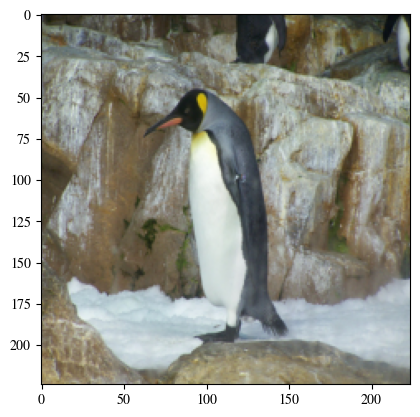

In [234]:
from PIL import Image
import matplotlib.pyplot as plt

# plt.imshow(image[0].cpu().permute(1,2,0))
plt.imshow((image[0].cpu().permute(1,2,0) + 1) /2)
raw_pred = wrapped_vit(image.cuda()).argmax(-1).item()
set_random_seed(42)
smooth_pred = cert_mus_vit(image.cuda())['logits'].argmax(-1).item()
print(image.shape)
print('raw_pred', raw_vit.config.id2label[raw_pred], raw_pred)
print('smooth_pred', raw_vit.config.id2label[smooth_pred], smooth_pred)

# get top_k predictions
top_k = 10
top_k_preds = get_top_k_predictions(wrapped_vit, image, raw_vit, k=top_k)

# Print the top k predictions
for rank, (label_id, label_name, logit, prob) in enumerate(top_k_preds, start=1):
    print(f"Rank {rank}: Label ID = {label_id}, Label = {label_name}, Logit = {logit:.4f}, Probability = {prob:.4f}")

In [235]:
# r = 0.25
num_patches=grid_size * grid_size #49
top_k_frac = 0.5 #0.25

  0%|          | 0/1000 [00:00<?, ?it/s]

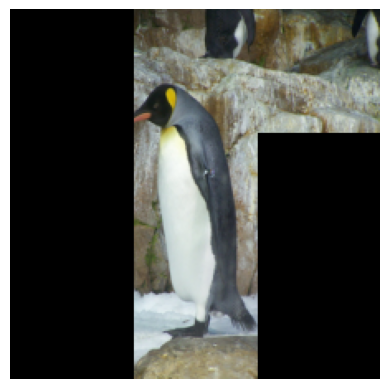

In [236]:
set_random_seed(42)
lime_expln_alpha, lime_expln, lime_expln_attrs = get_lime_for_image(wrapped_vit, 
                                                                    image[0], return_verbose=True,
                                                                   num_patches=num_patches, top_k_frac=top_k_frac)
vis_masked_img(image=image.cpu(), alpha=lime_expln_alpha.cpu()) 

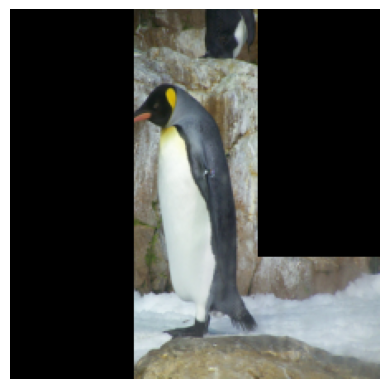

In [237]:
set_random_seed(42)
shap_expln_alpha, shap_expln, shap_expln_attrs = get_shap_for_image(wrapped_vit, 
                                                                    image[0], return_verbose=True,
                                                                   num_patches=num_patches, top_k_frac=top_k_frac)
vis_masked_img(image=image.cpu(), alpha=shap_expln_alpha.cpu()) 

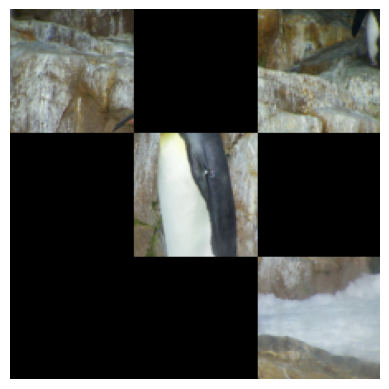

In [238]:
# set_random_seed(42)
# intgrad_expln_alpha, intgrad_expln, intgrad_expln_attrs = get_intgrad_for_image(wrapped_vit, 
#                                                                     image[0], return_verbose=True,
#                                                                    num_patches=num_patches, top_k_frac=top_k_frac)
# vis_masked_img(image=image.cpu(), alpha=intgrad_expln_alpha.cpu()) 

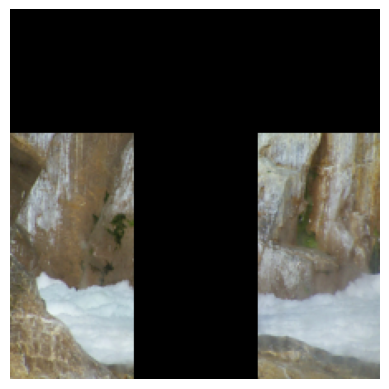

In [239]:
# set_random_seed(42)
# mfaba_expln_alpha, mfaba_expln, mfaba_expln_attrs = get_mfaba_for_image(wrapped_vit, 
#                                 image[0], return_verbose=True,
#                                 num_patches=num_patches, top_k_frac=top_k_frac)
# vis_masked_img(image=image.cpu(), alpha=mfaba_expln_alpha.cpu()) 

In [241]:
exp = lime_expln_alpha

set_random_seed(42)
ss_list = []
for r in range(1, 6):
    ss = soft_stability_rate(wrapped_vit, image[0].to(device), exp.to(device), r, epsilon=0.1).item()
    ss_list.append(ss)
print('soft stability', ss_list)
set_random_seed(42)
mus_output = cert_mus_vit(image.to(device), alpha=exp.to(device))
hs_radius = mus_output["cert_rs"]
smooth_pred = mus_output['logits'].argmax(-1).item()
print('hard stability radius', hs_radius)
print('smooth_pred', raw_vit.config.id2label[smooth_pred], smooth_pred)

soft stability [1.0, 1.0, 1.0, 1.0, 1.0]
hard stability radius tensor([1.], device='cuda:0')
smooth_pred king penguin, Aptenodytes patagonica 145


In [206]:
exp = shap_expln_alpha

ss_list = []
for r in tqdm(range(1, 6)):
# for r in tqdm(range(0, 196, 10)):
    set_random_seed(42)
    ss = soft_stability_rate(wrapped_vit, image[0].to(device), exp.to(device), r, epsilon=0.1).item()
    ss_list.append(ss)
print('soft stability', ss_list)
set_random_seed(42)
mus_output = cert_mus_vit(image.to(device), alpha=exp.to(device))
hs_radius = mus_output["cert_rs"]
smooth_pred = mus_output['logits'].argmax(-1).item()
print('hard stability radius', hs_radius)
print('smooth_pred', raw_vit.config.id2label[smooth_pred], smooth_pred)

  0%|          | 0/5 [00:00<?, ?it/s]

soft stability [1.0, 1.0, 1.0, 1.0, 1.0]
hard stability radius tensor([0.1961], device='cuda:0')
smooth_pred revolver, six-gun, six-shooter 763


In [186]:
set_random_seed(1)
hs_radius = cert_mus_vit(image.to(device), alpha=exp.to(device))["cert_rs"]
print('hard stability radius', hs_radius)

hard stability radius tensor([1.4833], device='cuda:0')


In [187]:
set_random_seed(2)
hs_radius = cert_mus_vit(image.to(device), alpha=exp.to(device))["cert_rs"]
print('hard stability radius', hs_radius)

hard stability radius tensor([1.6500], device='cuda:0')


In [188]:
set_random_seed(3)
hs_radius = cert_mus_vit(image.to(device), alpha=exp.to(device))["cert_rs"]
print('hard stability radius', hs_radius)

hard stability radius tensor([1.2833], device='cuda:0')


In [189]:
set_random_seed(4)
hs_radius = cert_mus_vit(image.to(device), alpha=exp.to(device))["cert_rs"]
print('hard stability radius', hs_radius)

hard stability radius tensor([1.2667], device='cuda:0')


In [207]:
exp = intgrad_expln_alpha

ss_list = []
for r in range(1, 6):
    set_random_seed(42)
    ss = soft_stability_rate(wrapped_vit, image[0].to(device), exp.to(device), r, epsilon=0.1).item()
    ss_list.append(ss)
print('soft stability', ss_list)
mus_output = cert_mus_vit(image.to(device), alpha=exp.to(device))
hs_radius = mus_output["cert_rs"]
smooth_pred = mus_output['logits'].argmax(-1).item()
print('hard stability radius', hs_radius)
print('smooth_pred', raw_vit.config.id2label[smooth_pred], smooth_pred)

soft stability [1.0, 1.0, 1.0, 1.0, 1.0]
hard stability radius tensor([0.0392], device='cuda:0')
smooth_pred revolver, six-gun, six-shooter 763


In [208]:
exp = mfaba_expln_alpha

ss_list = []
for r in range(1, 6):
    set_random_seed(42)
    ss = soft_stability_rate(wrapped_vit, image[0].to(device), exp.to(device), r, epsilon=0.1).item()
    ss_list.append(ss)
print('soft stability', ss_list)
mus_output = cert_mus_vit(image.to(device), alpha=exp.to(device))
hs_radius = mus_output["cert_rs"]
smooth_pred = mus_output['logits'].argmax(-1).item()
print('hard stability radius', hs_radius)
print('smooth_pred', raw_vit.config.id2label[smooth_pred], smooth_pred)

soft stability [0.3466666638851166, 0.1666666716337204, 0.1066666692495346, 0.06666667014360428, 0.10000000149011612]
hard stability radius tensor([0.4510], device='cuda:0')
smooth_pred revolver, six-gun, six-shooter 763


# Save masked images

In [242]:
import os
save_dir = f'_fig_images/masked/{image_name}_gs{grid_size}'
os.makedirs(save_dir, exist_ok=True)

In [243]:
r = 5
exp_mapping = {
    'lime': lime_expln_alpha,
    'shap': shap_expln_alpha,
    'intgrad': intgrad_expln_alpha,
    'mfaba': mfaba_expln_alpha
}
exp_name = 'lime'
alpha = exp_mapping[exp_name]
# alpha = shap_expln_alpha

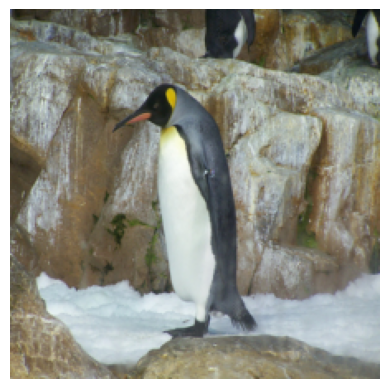

In [244]:
plt.imshow((image[0].permute(1,2,0) + 1)/2)
plt.axis('off')
plt.savefig(os.path.join(save_dir, f'{exp_name}_original.png'), 
    dpi=300, bbox_inches='tight', pad_inches=0)

In [245]:
vis_masked_img(image=image.cpu(), alpha=alpha.cpu(),
            save_path=os.path.join(save_dir, 
                f'{exp_name}_alpha{alpha.sum().item()}.png'))

In [246]:
import math
from stability import sample_alpha_pertbs
@torch.no_grad()
def soft_stability_rate_with_alphas(
    f,
    x: torch.FloatTensor,
    alpha: torch.LongTensor,
    radius: int,
    epsilon: float = 0.1,
    delta: float = 0.1,
    batch_size: int = 16,
    return_all: bool = False,
):
    """
    Measure the soft stability rate for a classifier of form y = f(x, alpha), where:

        soft_stability_rate = Pr_{alpha' ~ Delta_r} [f(x, alpha') == f(x, alpha)]

    Args:
        f: Any function (ideally nn.Module) that takes as input x, alpha.
        x: The input to f of some shape. NOT batched.
        alpha: The 0/1 attribution of some shape. NOT batched.
        radius: The radius to which we give the guarantee.
        epsilon: The error tolerance.
        delta: The admissible failure probability
        batch_size: The batch size in case we run out-of-memory.
        return_all: Return all the intermediate information in a dictionary.

    Returns:
        soft_stability_rate: A value between 0 and 1.
    """
    C, H, W = x.shape
    y = f(x.view(1,C,H,W), alpha.unsqueeze(0)) # Reference prediction

    N = int(math.log(2/delta) / (2 * (epsilon**2))) + 1
    all_y_pertbs = []
    all_alpha_pertbs = []

    for alpha_pertbs in torch.split(sample_alpha_pertbs(alpha, radius, N), batch_size):
        repeat_pattern = [1] * (1 + x.ndim)
        repeat_pattern[0] = alpha_pertbs.size(0)
        y_pertbs = f(x.unsqueeze(0).repeat(*repeat_pattern), alpha_pertbs)
        all_y_pertbs.append(y_pertbs)
        all_alpha_pertbs.append(alpha_pertbs)

    all_y_pertbs = torch.cat(all_y_pertbs, dim=0)
    soft_stab_rate = (y.argmax(dim=-1) == all_y_pertbs.argmax(dim=-1)).float().mean()
    all_alpha_pertbs = torch.cat(all_alpha_pertbs, dim=0)
    
    if return_all:
        return {
            "soft_stability_rate": soft_stab_rate,
            "y": y[0],
            "y_pertbs": all_y_pertbs,
            'alpha_pertbs': all_alpha_pertbs
        }

    else:
        return soft_stab_rate

In [154]:
set_random_seed(0)
ss_dict = soft_stability_rate_with_alphas(wrapped_vit, image[0].to(device), alpha.to(device), r, epsilon=0.1,
                                    return_all=True)

In [155]:
ss_dict['alpha_pertbs'].shape, ss_dict['y_pertbs'].shape

(torch.Size([150, 1, 7, 7]), torch.Size([150, 1000]))

In [156]:
r, set(ss_dict['y_pertbs'].argmax(-1).tolist())

(4, {162, 166})

In [161]:
ss_dict['y_pertbs'].argmax(-1).tolist().count(162), ss_dict['y_pertbs'].argmax(-1).tolist().count(166)

(11, 139)

In [162]:
raw_vit.config.id2label[162], raw_vit.config.id2label[166]

('beagle', 'Walker hound, Walker foxhound')

In [163]:
wrong_idx1 = ss_dict['y_pertbs'].argmax(-1).tolist().index(162)
wrong_idx1

12

In [164]:
# wrong_idx2 = ss_dict['y_pertbs'].argmax(-1).tolist().index(960)
# wrong_idx2

In [182]:
ss_dict['alpha_pertbs'].sum(-1).sum(-1).view(-1).tolist().index(14), ss_dict['alpha_pertbs'].sum(-1).sum(-1).view(-1).tolist().index(15), ss_dict['alpha_pertbs'].sum(-1).sum(-1).view(-1).tolist().index(16)

(128, 2, 0)

In [190]:
alphas_idxs = torch.tensor([128,2,wrong_idx1,0,50,100,149]).to(device)
alphas_plot = ss_dict['alpha_pertbs'][alphas_idxs]

In [191]:
alpha.sum()

tensor(12., device='cuda:0')

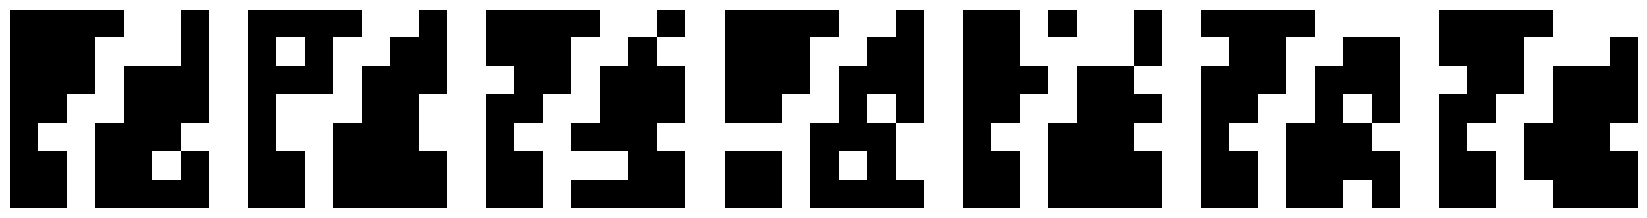

In [192]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 7, figsize=(3*7, 3))
for i in range(len(axs)):
    axs[i].imshow(alphas_plot[i][0].cpu(), cmap='gray')
    axs[i].axis('off')

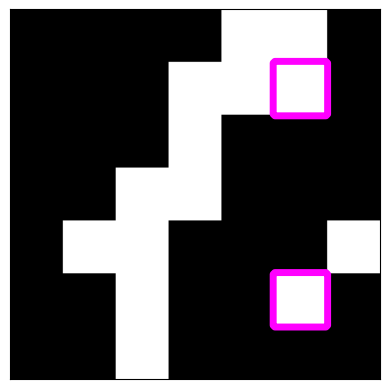

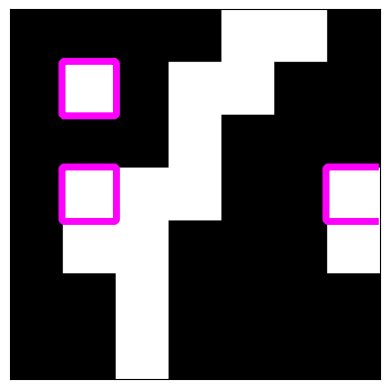

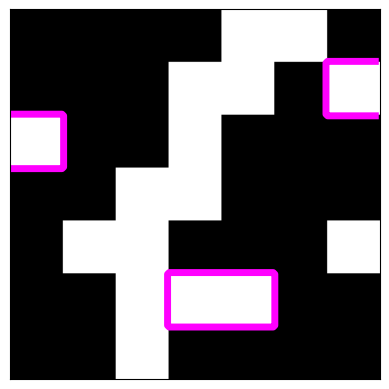

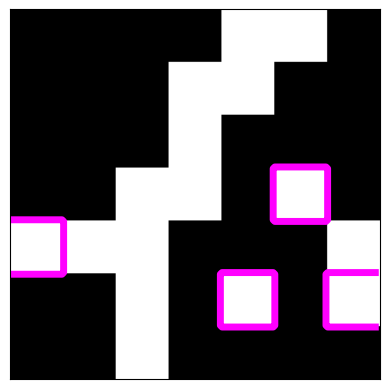

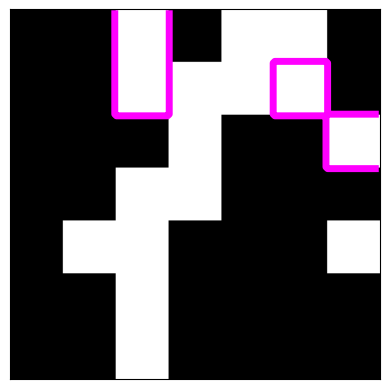

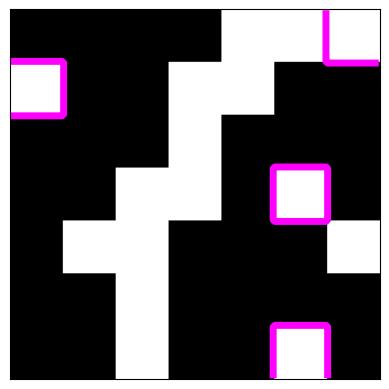

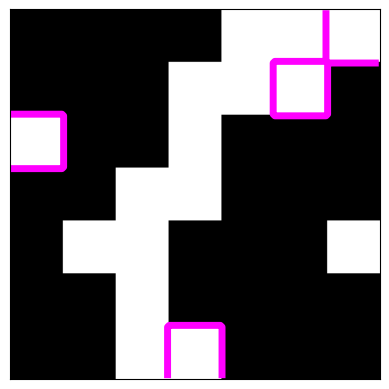

In [224]:
import numpy as np
import torch.nn.functional as F
os.makedirs(os.path.join(save_dir, 'masks_only'), exist_ok=True)
for i in range(len(alphas_plot)):
    plt.figure()
    mask = F.interpolate(alphas_plot[i:i+1].float().cpu(), size=(224, 224))
    plt.imshow(mask[0][0].cpu(), cmap='gray')
    diff_mask = (alphas_plot[i][0].cpu() - alpha.cpu())
    contour_levels = np.linspace(diff_mask.numpy().min(), diff_mask.numpy().max(), 10)
    diff_mask_large = F.interpolate(diff_mask[None].float().cpu(), size=(224, 224))[0][0]
    plt.contour(diff_mask_large, levels=[0], colors='#ff00ff', linewidths=5)
    # plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join(save_dir, 'masks_only', f'rand_mask{i}.png'), dpi=300, bbox_inches='tight', pad_inches=0)

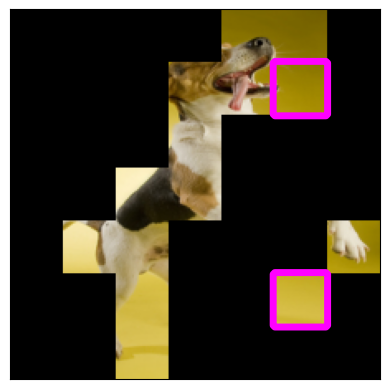

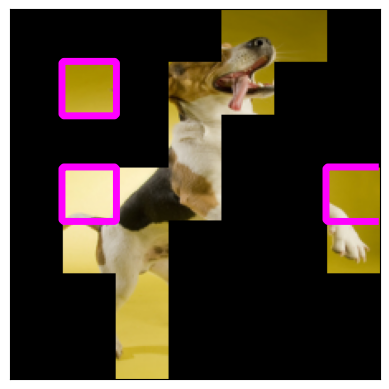

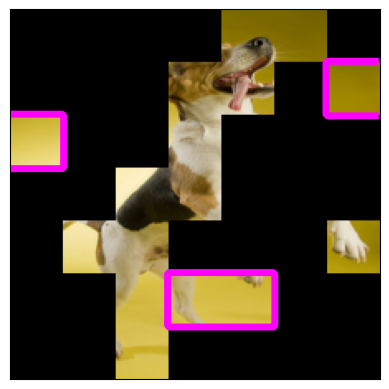

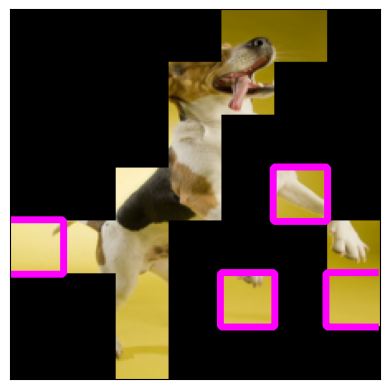

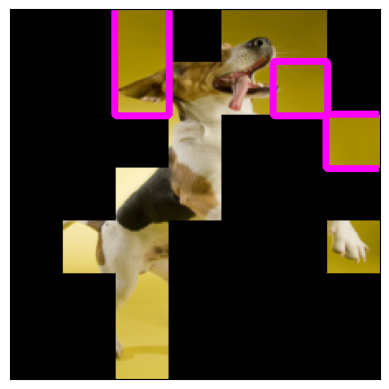

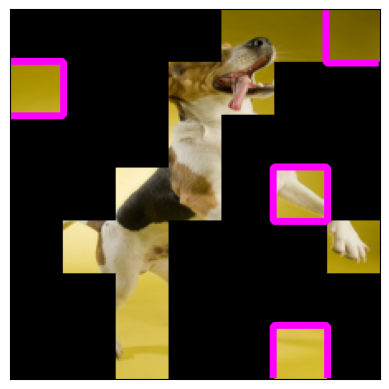

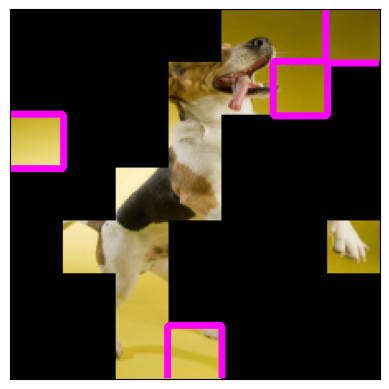

In [225]:
import torch.nn.functional as F
os.makedirs(os.path.join(save_dir, 'masks_n_img'), exist_ok=True)
for i in range(len(alphas_plot)):
    plt.figure()
    mask = F.interpolate(alphas_plot[i:i+1].float().cpu(), size=(224, 224))
    # print('mask', mask.shape)
    # print('image', image.shape)
    plt.imshow(((image.cpu() + 1) / 2 * mask.cpu())[0].permute(1,2,0).cpu())
    diff_mask = (alphas_plot[i][0].cpu() - alpha.cpu())
    contour_levels = np.linspace(diff_mask.numpy().min(), diff_mask.numpy().max(), 10)
    diff_mask_large = F.interpolate(diff_mask[None].float().cpu(), size=(224, 224))[0][0]
    plt.contour(diff_mask_large, levels=[0], colors='#ff00ff', linewidths=5)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join(save_dir, 'masks_n_img', f'rand_mask{i}.png'), dpi=300, bbox_inches='tight', pad_inches=0)

In [226]:
alpha.shape

torch.Size([1, 7, 7])

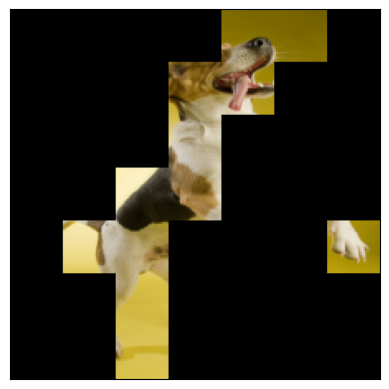

In [227]:
import torch.nn.functional as F
os.makedirs(os.path.join(save_dir, 'masks_n_img'), exist_ok=True)
# for i in range(len(alphas_plot)):
plt.figure()
mask = F.interpolate(alpha[None].float().cpu(), size=(224, 224))
# print('mask', mask.shape)
# print('image', image.shape)
plt.imshow(((image.cpu() + 1) / 2 * mask.cpu())[0].permute(1,2,0).cpu())
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(save_dir, 'masks_n_img', f'rand_mask_{exp_name}.png'), dpi=300, bbox_inches='tight', pad_inches=0)

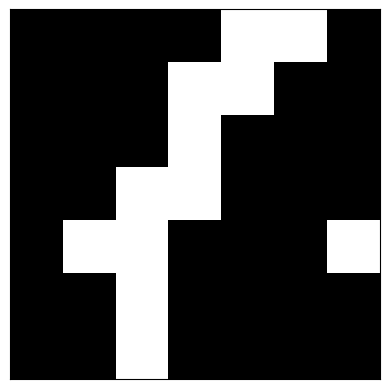

In [228]:
os.makedirs(os.path.join(save_dir, 'masks_only'), exist_ok=True)
# for i in range(len(alphas_plot)):
plt.figure()
plt.imshow(alpha[0].cpu(), cmap='gray')
# plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(save_dir, 'masks_only', f'rand_mask_{exp_name}.png'), dpi=300, bbox_inches='tight', pad_inches=0)

In [201]:
alpha_add1 = add_k_ones_enumerate(alpha, k=1)

In [1295]:
alpha_add1, alpha

([tensor([[[1., 1., 1.],
           [0., 1., 0.],
           [0., 1., 0.]]], device='cuda:0'),
  tensor([[[0., 1., 1.],
           [1., 1., 0.],
           [0., 1., 0.]]], device='cuda:0'),
  tensor([[[0., 1., 1.],
           [0., 1., 1.],
           [0., 1., 0.]]], device='cuda:0'),
  tensor([[[0., 1., 1.],
           [0., 1., 0.],
           [1., 1., 0.]]], device='cuda:0'),
  tensor([[[0., 1., 1.],
           [0., 1., 0.],
           [0., 1., 1.]]], device='cuda:0')],
 tensor([[[0., 1., 1.],
          [0., 1., 0.],
          [0., 1., 0.]]], device='cuda:0'))

In [1296]:
wrapped_vit_pred = wrapped_vit(image.to(device), alpha.to(device)).argmax(-1).item()
cert_mus_vit_pred = cert_mus_vit(image.to(device), alpha.to(device))['logits'].argmax(-1).item()
wrapped_vit_pred, cert_mus_vit_pred

(145, 145)

# fig 1 images

torch.Size([1, 3, 224, 224])
raw_pred king penguin, Aptenodytes patagonica
smooth_pred king penguin, Aptenodytes patagonica
Rank 1: Label ID = 145, Label = king penguin, Aptenodytes patagonica, Logit = 14.7724, Probability = 0.9995
Rank 2: Label ID = 146, Label = albatross, mollymawk, Logit = 4.0282, Probability = 0.0000
Rank 3: Label ID = 20, Label = water ouzel, dipper, Logit = 2.8947, Probability = 0.0000
Rank 4: Label ID = 96, Label = toucan, Logit = 2.8433, Probability = 0.0000
Rank 5: Label ID = 144, Label = pelican, Logit = 2.4834, Probability = 0.0000
Rank 6: Label ID = 150, Label = sea lion, Logit = 2.4716, Probability = 0.0000
Rank 7: Label ID = 36, Label = terrapin, Logit = 2.2415, Probability = 0.0000
Rank 8: Label ID = 383, Label = Madagascar cat, ring-tailed lemur, Lemur catta, Logit = 2.1386, Probability = 0.0000
Rank 9: Label ID = 10, Label = brambling, Fringilla montifringilla, Logit = 2.0663, Probability = 0.0000
Rank 10: Label ID = 143, Label = oystercatcher, oyster 

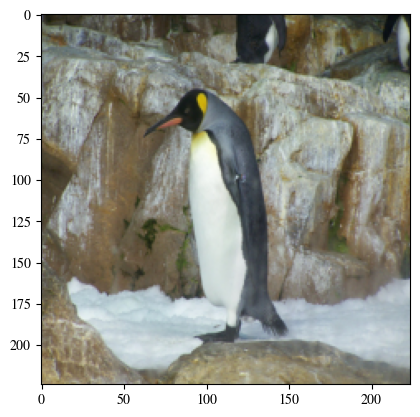

In [249]:
from PIL import Image
import matplotlib.pyplot as plt

# alpha_k1_i3 = add_k_ones_enumerate(alpha, k=1)[3][None]
alpha_show = alpha
# alpha_show = alphas_plot[2].float()
masked_image = image
# masked_image = image.to(device) * F.interpolate(alpha_show[None].to(device), size=(224, 224))

# plt.imshow(image[0].cpu().permute(1,2,0))
plt.imshow((masked_image[0].cpu().permute(1,2,0) + 1) /2)
raw_pred = wrapped_vit(image.cuda(), alpha_show[0]).argmax(-1).item()
set_random_seed(42)
smooth_pred = cert_mus_vit(image.cuda())['logits'].argmax(-1).item()
print(image.shape)
print('raw_pred', raw_vit.config.id2label[raw_pred])
print('smooth_pred', raw_vit.config.id2label[smooth_pred])

# get top_k predictions
top_k = 10
top_k_preds = get_top_k_predictions(wrapped_vit, 
                                    masked_image, raw_vit, k=top_k)

# Print the top k predictions
for rank, (label_id, label_name, logit, prob) in enumerate(top_k_preds, start=1):
    print(f"Rank {rank}: Label ID = {label_id}, Label = {label_name}, Logit = {logit:.4f}, Probability = {prob:.4f}")

In [256]:
def vis_masked_img(image: torch.Tensor, alpha: torch.Tensor, ax=plt, save_path=None, alpha_original: torch.Tensor = None, linewidths=5):
    """
    Visualize an image with an overlaid transparency mask and optional contour for difference.
    
    Args:
        image (torch.Tensor): Shape (1, 3, 224, 224), normalized in range [-1, 1].
        alpha (torch.Tensor): Shape (1, num_patches, num_patches).
        ax: Matplotlib axis or plt itself.
        save_path (str, optional): If provided, saves the figure to this path.
        alpha_original (torch.Tensor, optional): Original alpha for computing the difference.
    """
    mask = F.interpolate(alpha[:, None], size=(224, 224)).cpu()[0, 0]
    
    if alpha_original is not None:
        mask_original = F.interpolate(alpha_original[:, None], size=(224, 224)).cpu()[0, 0]
        diff_mask = (mask - mask_original).numpy()
    else:
        diff_mask = None
    
    if ax == plt:
        plt.figure()
    
    ax.imshow(((image[0] + 1) / 2 * mask).cpu().permute(1, 2, 0))
    ax.axis('off')
    
    # print('diff_mask', diff_mask)
    # print('mask_original', mask_original)
    
    # Draw contour if alpha_original is provided
    if diff_mask is not None:
        contour_levels = np.linspace(diff_mask.min(), diff_mask.max(), 10)
        ax.contour(diff_mask, levels=[0], colors='#ff00ff', linewidths=linewidths)
    
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()
    else:
        plt.show()

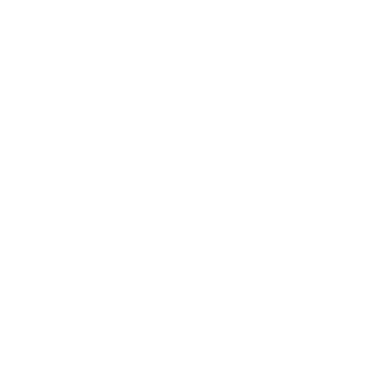

In [260]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

def vis_masks(image: torch.Tensor, alpha: torch.Tensor, ax=plt, save_path=None, 
                   alpha_original: torch.Tensor = None, linewidths=5):
    """
    Visualize an image with an overlaid transparency mask and optional contour for difference.
    
    Args:
        image (torch.Tensor): Shape (1, 3, 224, 224), normalized in range [-1, 1].
        alpha (torch.Tensor): Shape (1, num_patches, num_patches).
        ax: Matplotlib axis or plt itself.
        save_path (str, optional): If provided, saves the figure to this path.
        alpha_original (torch.Tensor, optional): Original alpha for computing the difference.
    """
    image = torch.ones_like(image)
    mask = F.interpolate(alpha[:, None], size=(224, 224)).cpu()[0, 0]
    
    if alpha_original is not None:
        mask_original = F.interpolate(alpha_original[:, None], size=(224, 224)).cpu()[0, 0]
        diff_mask = (mask - mask_original).numpy()
    else:
        diff_mask = None
    
    if ax == plt:
        plt.figure()
    
    ax.imshow(((image[0] + 1) / 2 * mask).cpu().permute(1, 2, 0))
    ax.axis('off')
    
    # print('diff_mask', diff_mask)
    # print('mask_original', mask_original)
    
    # Draw contour if alpha_original is provided
    if diff_mask is not None:
        contour_levels = np.linspace(diff_mask.min(), diff_mask.max(), 10)
        ax.contour(diff_mask, levels=[0], colors='#ff00ff', linewidths=linewidths)
    
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()
    else:
        plt.show()
        
vis_masks(image=image.cpu(), alpha=alpha_add.cpu())

In [261]:
import numpy as np
import torch.nn.functional as F

# compute pred
preds = []
wrapped_preds = []
cert_mus_preds = []
for k in range(1, 6):
    print('k', k)
    # try:
    alpha_add_k = add_k_ones_enumerate(alpha, k=k)
    # except:
    #     alpha_add_k = torch.ones_like(alpha)
    for i, alpha_add in tqdm(enumerate(alpha_add_k)):
        vis_masked_img(image=image.cpu(), alpha=alpha_add.cpu(), alpha_original=alpha.cpu(),
                      save_path=os.path.join(save_dir, 
                        f'{exp_name}_alpha{alpha.sum().item()}_k{k}_i{i}.png'), linewidths=15)
        vis_masks(image=image.cpu(), alpha=alpha_add.cpu(), alpha_original=alpha.cpu(),
                      save_path=os.path.join(save_dir, 
                        f'{exp_name}_alpha{alpha.sum().item()}_k{k}_i{i}_mask.png'), linewidths=15)
        wrapped_vit_pred = wrapped_vit(image.to(device), alpha_add.to(device)).argmax(-1).item()
        cert_mus_vit_pred = cert_mus_vit(image.to(device), alpha_add.to(device))['logits'].argmax(-1).item()
        preds.append(tuple([k, i, wrapped_vit_pred, cert_mus_vit_pred]))
        wrapped_preds.append(wrapped_vit_pred)
        cert_mus_preds.append(cert_mus_vit_pred)
        
#         if len(set(wrapped_preds)) > 1:
#             print('wrap')
#             break
        
#         if len(set(cert_mus_preds)) > 1:
#             print('cert')
#             break
        
        # print(i, 'wrapped_vit', wrapped_vit(image.to(device), alpha_add.to(device)).argmax(-1))
        # print(i, 'cert_mus_vit', cert_mus_vit(image.to(device), alpha_add.to(device))['logits'].argmax(-1))

k 1


0it [00:00, ?it/s]

k 2


0it [00:00, ?it/s]

k 3


0it [00:00, ?it/s]

k 4


0it [00:00, ?it/s]

k 5


0it [00:00, ?it/s]

In [262]:
preds

[(1, 0, 145, 145),
 (1, 1, 145, 145),
 (1, 2, 145, 145),
 (1, 3, 145, 145),
 (1, 4, 145, 145),
 (2, 0, 145, 145),
 (2, 1, 145, 145),
 (2, 2, 145, 145),
 (2, 3, 145, 145),
 (2, 4, 145, 145),
 (2, 5, 145, 145),
 (2, 6, 145, 145),
 (2, 7, 145, 145),
 (2, 8, 145, 145),
 (2, 9, 145, 145),
 (3, 0, 145, 145),
 (3, 1, 145, 145),
 (3, 2, 145, 145),
 (3, 3, 145, 145),
 (3, 4, 145, 145),
 (3, 5, 145, 145),
 (3, 6, 145, 145),
 (3, 7, 145, 145),
 (3, 8, 145, 145),
 (3, 9, 145, 145),
 (4, 0, 145, 145),
 (4, 1, 145, 145),
 (4, 2, 145, 145),
 (4, 3, 145, 145),
 (4, 4, 145, 145),
 (5, 0, 145, 145)]

In [263]:
# cert_mus_preds

In [264]:
cert_mus_preds, wrapped_preds

([145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145],
 [145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145,
  145])

In [265]:
set([pred[1].item() for pred in preds])

AttributeError: 'int' object has no attribute 'item'

In [ ]:
alpha_add = add_k_ones_enumerate(alpha, k=2)[5]
alpha_add

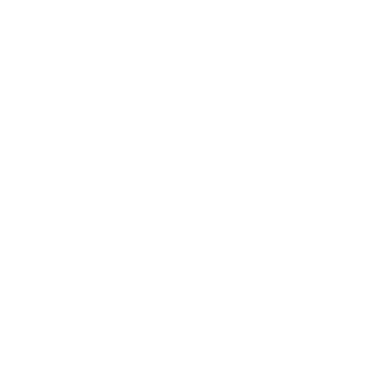

In [1283]:
alpha_add, alpha

(tensor([[[1., 1., 0.],
          [0., 1., 0.],
          [0., 0., 1.]]], device='cuda:0'),
 tensor([[[0., 1., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]], device='cuda:0'))

In [252]:
(image * F.interpolate(alpha_k2_i5, size=(224, 224))).shape

NameError: name 'F' is not defined

torch.Size([1, 3, 224, 224])
raw_pred coucal
smooth_pred revolver, six-gun, six-shooter
Rank 1: Label ID = 91, Label = coucal, Logit = 11.4892, Probability = 0.5752
Rank 2: Label ID = 95, Label = jacamar, Logit = 11.1120, Probability = 0.3945
Rank 3: Label ID = 379, Label = howler monkey, howler, Logit = 7.0684, Probability = 0.0069
Rank 4: Label ID = 16, Label = bulbul, Logit = 5.9474, Probability = 0.0023
Rank 5: Label ID = 94, Label = hummingbird, Logit = 5.8717, Probability = 0.0021
Rank 6: Label ID = 96, Label = toucan, Logit = 5.7525, Probability = 0.0019
Rank 7: Label ID = 364, Label = three-toed sloth, ai, Bradypus tridactylus, Logit = 5.3720, Probability = 0.0013
Rank 8: Label ID = 380, Label = titi, titi monkey, Logit = 5.0904, Probability = 0.0010
Rank 9: Label ID = 92, Label = bee eater, Logit = 4.8468, Probability = 0.0008
Rank 10: Label ID = 18, Label = magpie, Logit = 4.6497, Probability = 0.0006


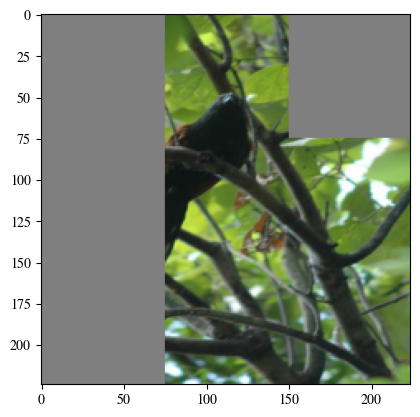

In [426]:
from PIL import Image
import matplotlib.pyplot as plt

alpha_k1_i3 = add_k_ones_enumerate(alpha, k=1)[3][None]
masked_image = image.to(device) * F.interpolate(alpha_k1_i3.to(device), size=(224, 224))

# plt.imshow(image[0].cpu().permute(1,2,0))
plt.imshow((masked_image[0].cpu().permute(1,2,0) + 1) /2)
raw_pred = wrapped_vit(image.cuda(), alpha_k1_i3[0]).argmax(-1).item()
set_random_seed(42)
smooth_pred = cert_mus_vit(image.cuda())['logits'].argmax(-1).item()
print(image.shape)
print('raw_pred', raw_vit.config.id2label[raw_pred])
print('smooth_pred', raw_vit.config.id2label[smooth_pred])

# get top_k predictions
top_k = 10
top_k_preds = get_top_k_predictions(wrapped_vit, 
                                    masked_image, raw_vit, k=top_k)

# Print the top k predictions
for rank, (label_id, label_name, logit, prob) in enumerate(top_k_preds, start=1):
    print(f"Rank {rank}: Label ID = {label_id}, Label = {label_name}, Logit = {logit:.4f}, Probability = {prob:.4f}")

torch.Size([1, 3, 224, 224])
raw_pred jacamar
smooth_pred revolver, six-gun, six-shooter
Rank 1: Label ID = 95, Label = jacamar, Logit = 11.5733, Probability = 0.4957
Rank 2: Label ID = 91, Label = coucal, Logit = 11.5361, Probability = 0.4776
Rank 3: Label ID = 379, Label = howler monkey, howler, Logit = 7.3062, Probability = 0.0070
Rank 4: Label ID = 380, Label = titi, titi monkey, Logit = 5.8738, Probability = 0.0017
Rank 5: Label ID = 96, Label = toucan, Logit = 5.8711, Probability = 0.0017
Rank 6: Label ID = 16, Label = bulbul, Logit = 5.7580, Probability = 0.0015
Rank 7: Label ID = 364, Label = three-toed sloth, ai, Bradypus tridactylus, Logit = 5.5600, Probability = 0.0012
Rank 8: Label ID = 94, Label = hummingbird, Logit = 5.5009, Probability = 0.0011
Rank 9: Label ID = 92, Label = bee eater, Logit = 5.0754, Probability = 0.0007
Rank 10: Label ID = 382, Label = squirrel monkey, Saimiri sciureus, Logit = 4.7502, Probability = 0.0005


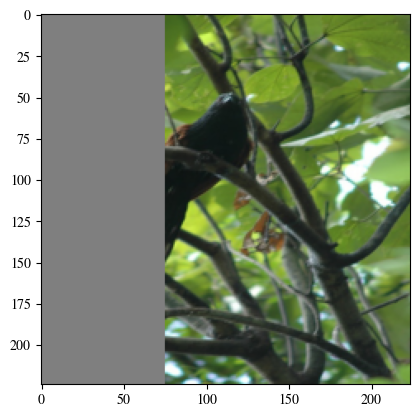

In [419]:
from PIL import Image
import matplotlib.pyplot as plt

alpha_k2_i5 = add_k_ones_enumerate(alpha, k=2)[5][None]
masked_image = image.to(device) * F.interpolate(alpha_k2_i5.to(device), size=(224, 224))

# plt.imshow(image[0].cpu().permute(1,2,0))
plt.imshow((masked_image[0].cpu().permute(1,2,0) + 1) /2)
raw_pred = wrapped_vit(image.cuda(), alpha_k2_i5[0]).argmax(-1).item()
set_random_seed(42)
smooth_pred = cert_mus_vit(image.cuda())['logits'].argmax(-1).item()
print(image.shape)
print('raw_pred', raw_vit.config.id2label[raw_pred])
print('smooth_pred', raw_vit.config.id2label[smooth_pred])

# get top_k predictions
top_k = 10
top_k_preds = get_top_k_predictions(wrapped_vit, 
                                    masked_image, raw_vit, k=top_k)

# Print the top k predictions
for rank, (label_id, label_name, logit, prob) in enumerate(top_k_preds, start=1):
    print(f"Rank {rank}: Label ID = {label_id}, Label = {label_name}, Logit = {logit:.4f}, Probability = {prob:.4f}")

In [406]:
# save masked images
for k in range(1, 6):
    print('k', k)
    try:
        alpha_add_k = add_k_ones_enumerate(alpha, k=k)
    except:
        alpha_add_k = torch.ones_like(alpha)
    # print(alpha_add_k.shape)
    for i, alpha_add in tqdm(enumerate(alpha_add_k)):
        vis_masked_img(image=image, alpha=alpha_add, 
            save_path=os.path.join(save_dir, 
                                  f'{exp_name}_alpha{alpha.sum().item()}_k{k}_i{i}.png'))

k 1


0it [00:00, ?it/s]

k 2


0it [00:00, ?it/s]

k 3


0it [00:00, ?it/s]

k 4


0it [00:00, ?it/s]

k 5


0it [00:00, ?it/s]